In [199]:
import math
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

class TwoLayerNet(nn.Module):
    def __init__(self,width=100,d_in=1,d_out=1):
        super(TwoLayerNet,self).__init__()
        self.fc1 = nn.Linear(d_in,width)
        self.fc2 = nn.Linear(width,d_out)
        self.d_in = d_in
        self.d_out = d_out
        self.width = width
        
    def initialize(self,stdv=-1,factor=1.0):
        if stdv != -1:
            self.fc1.weight.data.normal_(0,stdv)
            self.fc2.weight.data.normal_(0,stdv)
            self.fc1.bias.data.normal_(0,stdv)
            self.fc2.bias.data.normal_(0,stdv)
        else:
            stdv_1 = math.sqrt(factor/self.d_in)
            stdv_2 = math.sqrt(factor/self.width)
            self.fc1.weight.data.normal_(0,stdv_1)
            self.fc2.weight.data.normal_(0,stdv_2)
            
            self.fc1.bias.data.zero_()
            self.fc2.bias.data.zero_()
        
    def forward(self,x):
        o = self.fc1(x)
        o = F.relu(o)
        o = self.fc2(o)
        return o
    
    def path_norm(self,p=1):
        A = self.fc2.weight.data
        B = self.fc1.weight.data
        C = self.fc1.bias.data
        res = 0
        for i in range(self.width):
            b = abs(B[i,0]) + abs(C[i])
            res += abs(A[0,i])*b
        return res
    
    def group_norm(self):
        A = self.fc2.weight.data
        B = self.fc1.weight.data
        C = self.fc1.bias.data
        
        res = A.norm(p=2)*math.sqrt(B.norm(2)**2+C.norm(2)**2)
        return res
        
    
def visualize_weight(net):
    fig,axs = plt.subplots(1,4,figsize=(17,4))
    axs[0].plot(net.fc1.weight.data.view(-1).numpy(),'.')
    axs[0].set_title('fc1.weight')
    axs[1].plot(net.fc1.bias.data.view(-1).numpy(),'.')
    axs[1].set_title('fc1.bias')
    axs[2].plot(net.fc2.weight.data.view(-1).numpy(),'.')
    axs[2].set_title('fc2.weight')
    axs[3].plot(net.fc2.bias.data.view(-1).numpy(),'.')
    axs[3].set_title('fc2.bias')
    

In [175]:
# generate data
def gen_data(n=10):
    func = lambda t: t**3 - 3*t**2 - t + 1
    xR = np.linspace(-2,4,n)
    yR = func(xR)
    return xR,yR

In [259]:
m = 500
n = 8
lr = 0.001
niters = 10000


net = TwoLayerNet(m,1,1)
net.initialize(factor=0.1)
net0 = deepcopy(net)

loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(),lr=lr,momentum=0.9,nesterov=True)

xTrain,yTrain = gen_data(n)
X = torch.from_numpy(xTrain).view(n,1).float()
Y = torch.from_numpy(yTrain).view(n).float()

In [260]:
for i in range(niters):
    optimizer.zero_grad()
    X_var = Variable(X)
    Y_var = Variable(Y)
    O = net(X_var)
    E = loss_func(O,Y_var)
    E.backward()
    
    optimizer.step()
    if i%4000==0:
        print('%d,\t %.2e'%(i,E.data[0]))

0,	 6.45e+01
4000,	 4.61e-03
8000,	 4.96e-05


### Test model

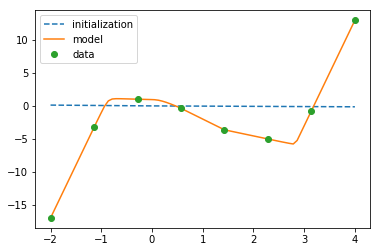

In [261]:
xTest = torch.linspace(-2,4,n*10).view(n*10,1)
yTest_p = net(Variable(xTest)).data
yTest_p0 = net0(Variable(xTest)).data

xTest = xTest.numpy()
yTest_p = yTest_p.numpy()
yTest_p0 = yTest_p0.numpy()


plt.plot(xTest,yTest_p0,'--',label='initialization')
plt.plot(xTest,yTest_p,'-',label='model')
plt.plot(xTrain,yTrain,'o',label='data')
plt.legend()

### Initialized Solution

==> initial path_norm: 1.38e+00, group_norm: 2.10e+00
network width is 500


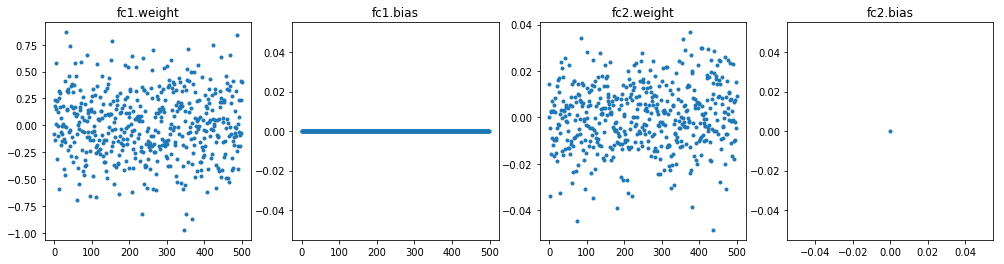

In [262]:
visualize_weight(net0)
print('==> initial path_norm: %.2e, group_norm: %.2e'%(net0.path_norm(),net0.group_norm()))
print('network width is %d'%(m))

### Trained Solution

==> final path_norm: 1.09e+02, group_norm: 8.88e+01
network width is 500


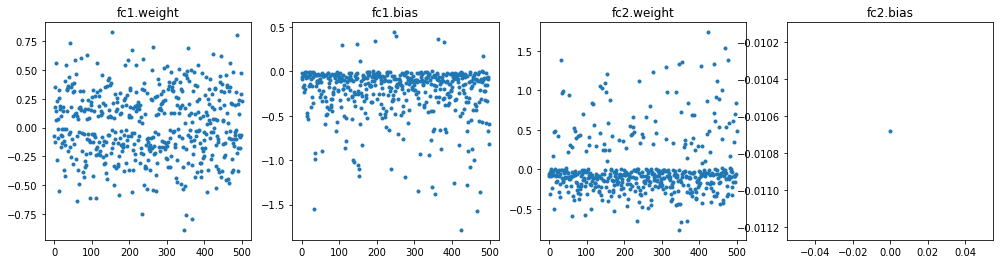

In [263]:
visualize_weight(net)
print('==> final path_norm: %.2e, group_norm: %.2e'%(net.path_norm(),net.group_norm()))
print('network width is %d'%(m))

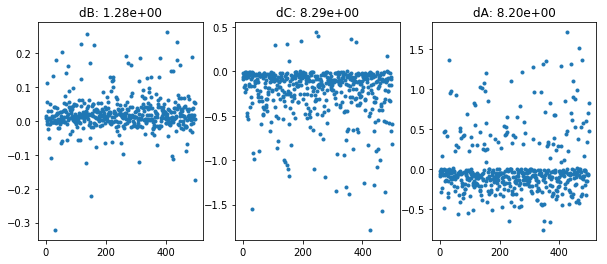

In [264]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
dB = net.fc1.weight.data - net0.fc1.weight.data
plt.title('dB: %.2e'%(dB.norm()))
plt.plot(dB.view(-1).numpy(),'.')

plt.subplot(1,3,2)
dC = net.fc1.bias.data - net0.fc1.bias.data
plt.title('dC: %.2e'%(dC.norm()))
plt.plot(dC.view(-1).numpy(),'.')

plt.subplot(1,3,3)
dA = net.fc2.weight.data - net0.fc2.weight.data
plt.title('dA: %.2e'%(dA.norm()))
plt.plot(dA.view(-1).numpy(),'.')

In [265]:
b = net.fc1.weight.data.view(-1)
c = net.fc1.bias.data.view(-1)
a = net.fc2.weight.data.view(-1)

print(a.norm()**2 - b.norm()**2-c.norm()**2)

-42.88676702587034


In [266]:
b = net0.fc1.weight.data.view(-1)
c = net0.fc1.bias.data.view(-1)
a = net0.fc2.weight.data.view(-1)

print(a.norm()**2 - b.norm()**2-c.norm()**2)

-46.43199377633074


---
### Test functions with the same path norm

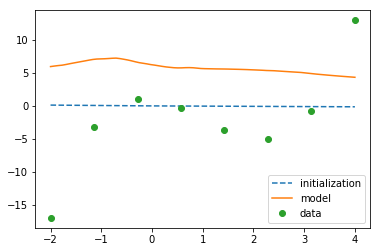

In [279]:
net_p = deepcopy(net)
A = net_p.fc2.weight.data
B = net_p.fc1.weight.data
C = net_p.fc1.bias.data

Q = torch.zeros_like(A).normal_(0,1)
T = A*Q
A.copy_(T)

Q = torch.zeros_like(C).normal_(0,1)
T = C*Q
C.copy_(T)

Q = torch.zeros_like(B).normal_(0,1)
T = B*Q
B.copy_(T)

xTest = torch.linspace(-2,4,n*10).view(n*10,1)
yTest_p = net_p(Variable(xTest)).data
yTest_p0 = net0(Variable(xTest)).data

xTest = xTest.numpy()
yTest_p = yTest_p.numpy()
yTest_p0 = yTest_p0.numpy()


plt.plot(xTest,yTest_p0,'--',label='initialization')
plt.plot(xTest,yTest_p,'-',label='model')
plt.plot(xTrain,yTrain,'o',label='data')
plt.legend()

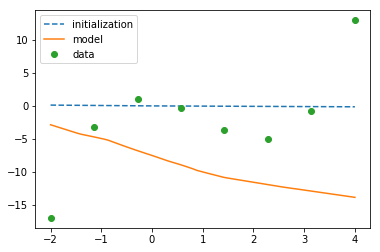

In [285]:
net_p = deepcopy(net)
A = net_p.fc2.weight.data
B = net_p.fc1.weight.data
C = net_p.fc1.bias.data

Q = torch.zeros_like(A).normal_(0,1)
T = A*A.sign()
A.copy_(T)

Q = torch.zeros_like(C).normal_(0,1)
T = C*C.sign()
C.copy_(T)

Q = torch.zeros_like(B).normal_(0,1)
T = B*B.sign()
B.copy_(T)

xTest = torch.linspace(-2,4,n*10).view(n*10,1)
yTest_p = net_p(Variable(xTest)).data
yTest_p0 = net0(Variable(xTest)).data

xTest = xTest.numpy()
yTest_p = yTest_p.numpy()
yTest_p0 = yTest_p0.numpy()


plt.plot(xTest,yTest_p0,'--',label='initialization')
plt.plot(xTest,yTest_p,'-',label='model')
plt.plot(xTrain,yTrain,'o',label='data')
plt.legend()